TODO
1) ~~nfsm basic node state~~
2) prune dp
2) nsfm add fd
3) nsfm add equiv
3) prune nfsm

In [912]:
!pip install networkx matplotlib



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [913]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(nodes, edges):
    G = nx.DiGraph()

    produced = []
    interesting = []
    drawable_edges = []
    for edge in edges:
        lhs = '(' + ','.join(nodes[edge.lhs].ordering.order) + ')'
        rhs = '(' + ','.join(nodes[edge.rhs].ordering.order) + ')'

        if nodes[edge.lhs].ordering.type == Ordering.Type.produced:
            lhs += ' P'
        elif nodes[edge.lhs].ordering.type == Ordering.Type.tested:
            lhs += ' T'
        if nodes[edge.rhs].ordering.type == Ordering.Type.produced:
            rhs += ' P'
        elif nodes[edge.rhs].ordering.type == Ordering.Type.tested:
            rhs += ' T'

        if nodes[edge.lhs].type == NFSMNode.Type.interesting:
            interesting.append(lhs)
        if nodes[edge.rhs].type == NFSMNode.Type.interesting:
            interesting.append(rhs)

        drawable_edges.append((lhs, rhs, {'label': edge.fd if edge.fd else 'eps'}))

    G.add_edges_from(drawable_edges)
    pos = nx.spring_layout(G, seed=1233, k=1.5, iterations=80)

    plt.figure(figsize=(14, 12))

    for u, v, d in G.edges(data=True):
        rad = 0.1 if G.has_edge(v, u) else 0
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)], connectionstyle=f'arc3,rad={rad}',
            edge_color='gray', arrows=True, arrowsize=10
        )

    node_colors = []
    for i, n in enumerate(G.nodes()):
        if n in interesting:
            node_colors.append('red')
        else:
            node_colors.append('lightblue')

    nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors)
    nx.draw_networkx_labels(G, pos, font_size=16)

    edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels,
        font_color='red', font_size=12, label_pos=0.7
    )

    plt.show()



In [914]:
import enum
import networkx as nx
import matplotlib.pyplot as plt

class FD:
    class Type(enum.Enum):
        eps = 0,
        equiv = 1,
        ordinary = 2

    def __init__(self, activation_nodes: str, required_nodes: str):
        if len(activation_nodes) == 0 and len(required_nodes) == 0:
            self.type = self.Type.eps
            
        self.activation_nodes = activation_nodes
        self.required_nodes = required_nodes


    def __repr__(self) -> str:
        return f'{self.activation_nodes} -> {self.required_nodes}'

class Ordering:
    class Type(enum.Enum):
        tested = 0
        produced = 1

    def __init__(self, order: list[str], type=''):
        self.order = order
        self.type = type

    def __repr__(self) -> str:
        return '(' + ','.join(self.order) + ')'


Type.interesting
Type.interesting
Type.interesting
init state
Nodes: [{(b), Type.interesting}, {(a,b), Type.interesting}, {(a,b,c), Type.interesting}]
Edges: 


Type.artificial
after prefix closure


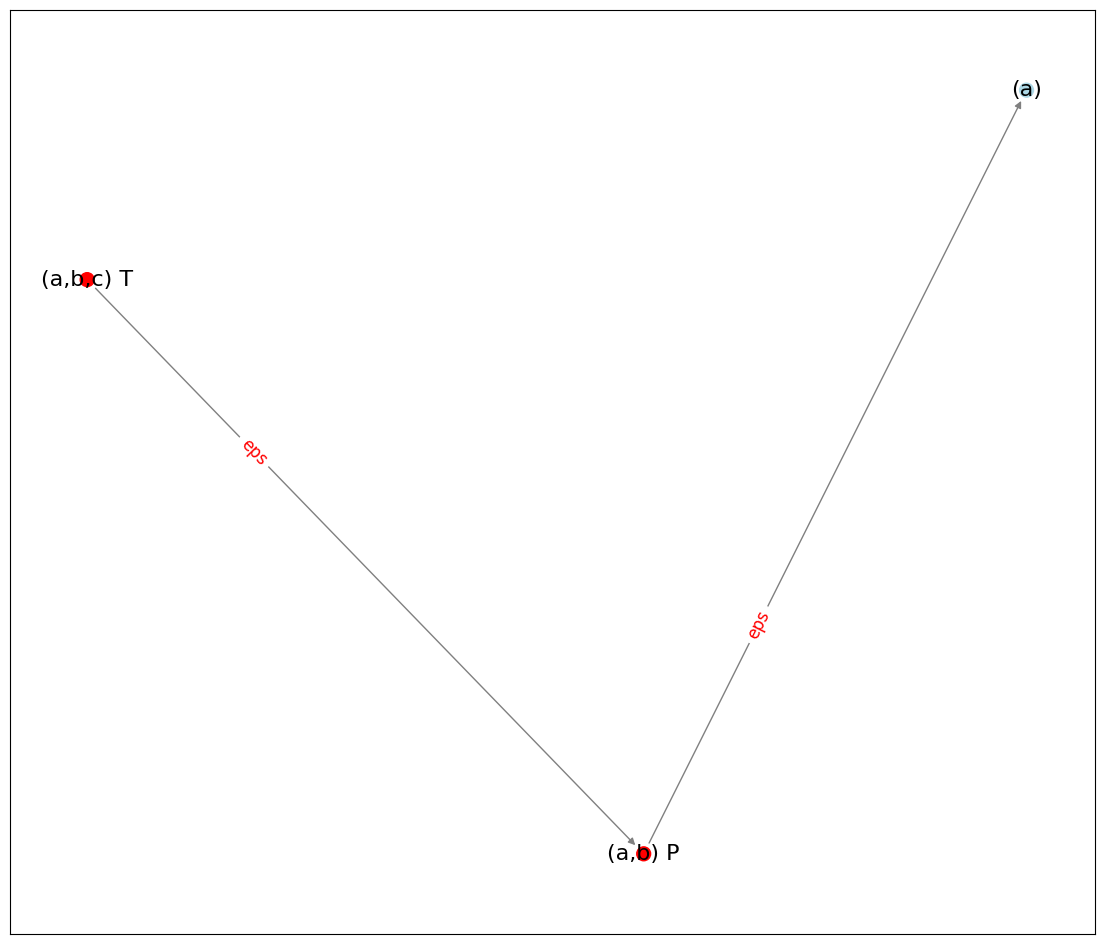

Nodes: [{(b), Type.interesting}, {(a,b), Type.interesting}, {(a,b,c), Type.interesting}, {(a), Type.artificial}]
Edges: 
{(a,b) -> (a), eps}
{(a,b,c) -> (a,b), eps}

Type.artificial
after applying fd


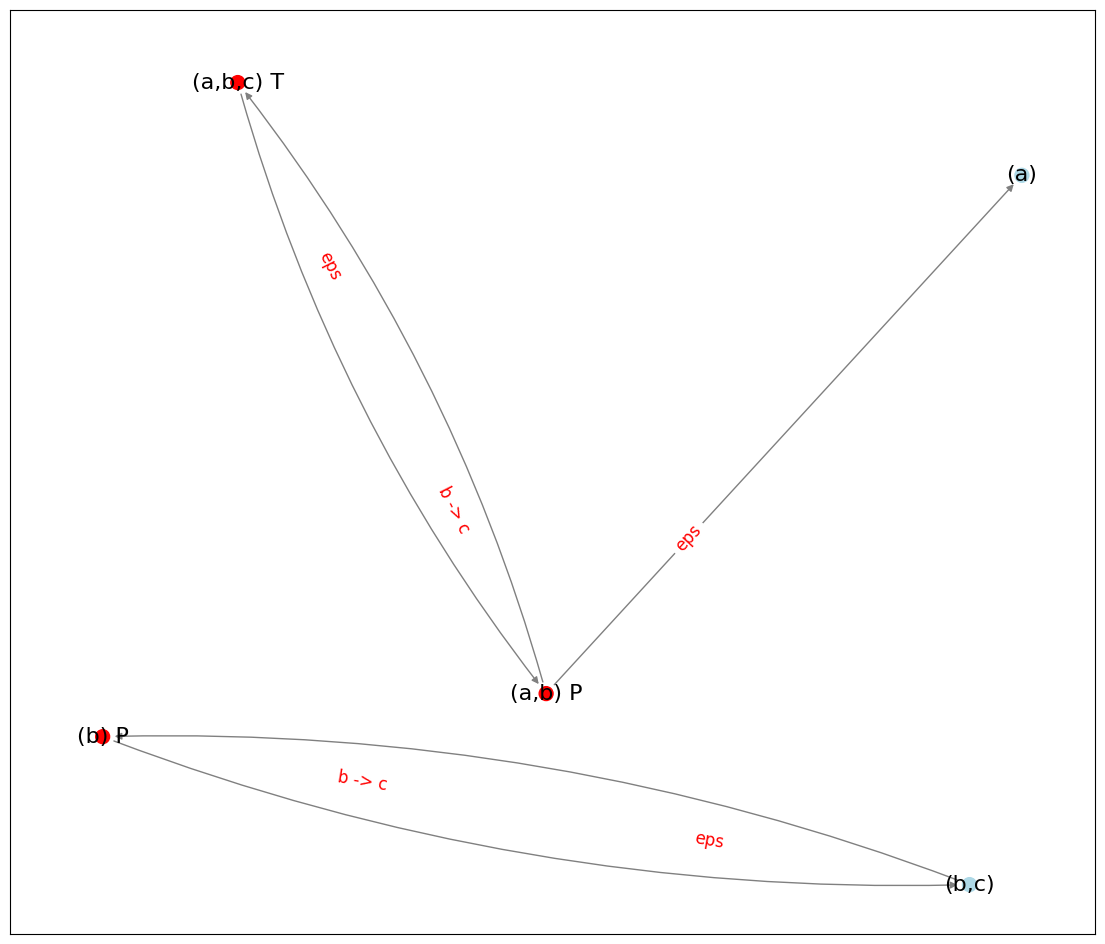

Nodes: [{(b), Type.interesting}, {(a,b), Type.interesting}, {(a,b,c), Type.interesting}, {(a), Type.artificial}, {(b,c), Type.artificial}]
Edges: 
{(a,b) -> (a), eps}
{(a,b,c) -> (a,b), eps}
{(b) -> (b,c), b -> c}
{(b,c) -> (b), eps}
{(a,b) -> (a,b,c), b -> c}



In [915]:
from copy import deepcopy
import warnings

class NFSMNode:
    class Type(enum.Enum):
        artificial = 0
        interesting = 1

    def __init__(self, ordering: Ordering, type: Type) -> None:
        print(type)
        self.ordering = ordering
        self.type = type

    def __repr__(self) -> str:
        # if self.Type not in (NFSMNode.Type.artificial, NFSMNode.Type.interesting):
        #     raise RuntimeError(f"{str(self.Type)} is not defined")
        # {"A" if self.type == NFSMNode.Type.artificial else "I"}
        return '{' + f'{self.ordering}, {self.type}' + '}'

class NFSMEdge:
    def __init__(self, lhs, rhs, fd: set[FD]) -> None:
        self.lhs = lhs
        self.rhs = rhs
        if fd == 'eps':
            self.fd = set()
        else:
            self.fd = fd

    def __repr__(self) -> str:
        return '{' + f'{self.lhs} -> {self.rhs}, {self.fd if self.fd else "eps"}' + '}'

    


class NFSM:
# public methods
    def __init__(self) -> None:
        self.nodes = []
        self.edges = []

    def contains(self):
        raise NotImplemented()
    
    def infer_new_logical_orderings(self, fd_set):
        raise NotImplemented()

    def construct(self, functional_dependencies, produced, tested):
        interesting_orderings = produced + tested
        self.add_init_nodes(interesting_orderings)
        self.debug_print('init state', False)

        self.prefix_closure()
        self.debug_print('after prefix closure', True)

        functional_dependencies = self.prune_dp(functional_dependencies)
        self.apply_fd(functional_dependencies)
        self.debug_print('after applying fd', True)


        self.prune_nodes()


# private methods
    def add_init_nodes(self, interesting_ordering):
        for ordering in interesting_ordering:
            self.nodes.append(NFSMNode(ordering, NFSMNode.Type.interesting))

    def prefix_closure(self):
        for ordering in [node.ordering for node in self.nodes]:
            for i in range(1, len(ordering.order)):
                self.add_node(ordering.order[:i])  

        for idx1, ordering1 in enumerate([node.ordering.order for node in self.nodes]):
            for idx2, ordering2 in enumerate([node.ordering.order for node in self.nodes]):
                if ordering1[:len(ordering1) - 1] == ordering2:
                    self.add_edge(idx1, idx2, 'eps')
                    break
                  

    def prune_dp(self, functional_dependencies):
        new_fds = []
        for fd in functional_dependencies:
            used = False
            for idx, node in enumerate(self.nodes):
                if node.type == NFSMNode.Type.interesting and node.ordering.order.count(fd.required_nodes) > 0:
                    used = True
                    break

            if used:
               new_fds.append(fd)

        return new_fds 


    def apply_fd(self, functional_dependencies):
        node_idx = 0

        while node_idx < len(self.nodes):
            node = self.nodes[node_idx]

            for fd in functional_dependencies:
                if fd.activation_nodes in node.ordering.order and fd.required_nodes not in node.ordering.order: # 'b', 
                    pos = node.ordering.order.index(fd.activation_nodes)
                    for i in range(pos + 1, len(node.ordering.order) + 1):
                        new_order = list(node.ordering.order)
                        new_order.insert(i, fd.required_nodes)
                        r_idx = self.add_node(new_order)    
                        self.add_edge(node_idx, r_idx, fd)
                        self.add_edge(r_idx, node_idx, 'eps') 

            node_idx += 1
 
    def prune_nodes(self):
        interesting_indexies = []
        for idx, node in enumerate(self.nodes):
            if node.ordering.type == Ordering.Type.tested:
                pass


    def add_edge(self, l_idx, r_idx, fd):
        for edge in self.edges:
            if l_idx == edge.lhs and r_idx == edge.rhs:
                return edge
            
        self.edges.append(NFSMEdge(l_idx, r_idx, fd))

    def add_node(self, ordering: list[str]) -> int:
        for idx, node in enumerate(self.nodes):
            if node.ordering.order == ordering:
                return idx
            
        node = NFSMNode(ordering=Ordering(ordering), type=NFSMNode.Type.artificial)
        self.nodes.append(node)
        return len(self.nodes) - 1
    
    def debug_print(self, msg = '', draw = False):
        if msg:
            print(msg)
        if draw:
            draw_graph(self.nodes, self.edges)
        print(self)

    def __repr__(self) -> str:
        edges = []
        for e in self.edges:
            l = '(' + ','.join(self.nodes[e.lhs].ordering.order) + ')'
            r = '(' + ','.join(self.nodes[e.rhs].ordering.order) + ')'
            edges.append('{' + f'{l} -> {r}, {e.fd if e.fd else "eps"}' + '}')
        
        str_e = "\n".join(edges)
        return f'Nodes: {self.nodes}\nEdges: \n{str_e}\n'

def create_orderings(orderings : list[str], type: Ordering.Type):
    res = []
    for ordering in orderings:
        res.append(Ordering(list(ordering), type))
    return res


produced = create_orderings(['b', 'ab'], Ordering.Type.produced)
tested = create_orderings(['abc'], Ordering.Type.tested)

fds = [
    FD('b', 'c'),
    FD('b', 'd'),
]

nfsm = NFSM()
nfsm.construct(fds, produced, tested)


# fds = [
#     FD('a', 'b'),
#     # FD('')
# ]
